### Import Libraries

In [2]:
# Importing necessary libraries for data loading, data manipulation, and data visualization
from datasets import load_from_disk, concatenate_datasets
from tqdm import tqdm
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import nltk
import re

from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from gensim import corpora, models

# Preprocessing

In [2]:
####### This is the code to generate the tokens using SpaCy ####### 

# The run takes 3:30 hours approximately

# from datasets import load_dataset
# import re
# import spacy
# dataset_train=load_dataset("yelp_review_full",split='train')
# dataset_test=load_dataset("yelp_review_full",split='test')
# nlp = spacy.load("en_core_web_sm")

# # Preprocessing function for each review
# def clean_sentence(sentence):
#     sentence = re.sub(r'\\n',"",sentence)

#     #removing emoticons
#     sentence = re.sub(r'(\:\w+\:|\<[\/\\]?3|[\(\)\\\D|\*\$][\-\^]?[\:\;\=]|[\:\;\=B8][\-\^]?[3DOPp\@\$\*\\\)\(\/\|])(?=\s|[\!\.\?]|$)',"", sentence)

#     #removing websites
#     sentence = re.sub(r"(http)?s?:?\/\/[A-Za-z0-9^,!.\/'+-=_?]+", "", sentence)

#     #numbers
#     sentence = re.sub(r"(\d+)(k)", r"\g<1> thousand", sentence)
#     sentence = re.sub(r"(\d+)([a-zA-z]+)", r"\g<1> \g<2>", sentence)
#     #convert numbers to words
#     sentence = re.sub(r"1", " one ", sentence)
#     sentence = re.sub(r"2", " two ", sentence)
#     sentence = re.sub(r"3", " three ", sentence)
#     sentence = re.sub(r"4", " four ", sentence)
#     sentence = re.sub(r"5", " five ", sentence)
#     sentence = re.sub(r"6", " six ", sentence)
#     sentence = re.sub(r"7", " seven ", sentence)
#     sentence = re.sub(r"8", " eight ", sentence)
#     sentence = re.sub(r"9", " nine ", sentence)
#     sentence = re.sub(r"0", " zero ", sentence)

#     # removing extraneous symbols
#     sentence = re.sub(r"[^A-Za-z0-9^,!.\/'+-=%]", " ", sentence)

#     # expanding contraction
#     sentence = re.sub(r"\'ve", " have ", sentence)
#     sentence = re.sub(r"n't", " not ", sentence)
#     sentence = re.sub(r"i'm", " i am ", sentence)
#     sentence = re.sub(r"\'re", " are ", sentence)
#     sentence = re.sub(r"\'d", " would ", sentence)
#     sentence = re.sub(r"\'ll", " will ", sentence)

#     #spacing out symbols
#     sentence = re.sub(r",", " ", sentence)
#     sentence = re.sub(r"\.", " . ", sentence)
#     sentence = re.sub(r"!", " ! ", sentence)
#     sentence = re.sub(r"\/", " ", sentence)
#     sentence = re.sub(r"\^", " ^ ", sentence)
#     sentence = re.sub(r"\+", " + ", sentence)
#     sentence = re.sub(r"\-", " - ", sentence)
#     sentence = re.sub(r"\=", " = ", sentence)
#     sentence = re.sub(r"'", " ", sentence)
#     sentence = re.sub(r":", " : ", sentence)
#     sentence = re.sub(r"%", " : ", sentence)

#     return sentence

# def preprocess_reviews(doc):
#     doc['text'] = clean_sentence(doc['text'])
#     return doc
    
# dataset_train = dataset_train.map(preprocess_reviews, num_proc = 4)
# dataset_test = dataset_test.map(preprocess_reviews, num_proc = 4)

# # Parsing function
# def parse_document(doc):
#   parsed_doc = nlp(doc['text'])
#   doc['sentences'] = [sent.text for sent in parsed_doc.sents]
#   doc['tokens'] = [w.text for w in parsed_doc]
#   return doc

# # Parse the reviews
# dataset_train = dataset_train.map(parse_document, num_proc = 4)
# dataset_test = dataset_test.map(parse_document, num_proc = 4)

# # Save to drive the preprocessed dataset
# dataset_train.save_to_disk('parsed_train.hf')
# dataset_test.save_to_disk('parsed_test.hf')


In [3]:
# Load the train and test datasets from disk: this dataset differs from the original 
# Yelp reviews dataset by having columns 'tokens' and 'sentences' that contain respectively
# the tokens and the sentences present in each review. This was done through SpaCy parsing.
train_dataset = load_from_disk('parsed_yelp_reviews//gianni_train.hf')
test_dataset = load_from_disk('parsed_yelp_reviews//gianni_test.hf')

In [4]:
# Function to remove punctuation from tokens of a document, returning a new column 'tokens_no_punc'
# that contains only tokens not corresponding to punctuation marks.
def remove_punctuation(doc):
    punc = '!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~ '
    doc['tokens_no_punc'] = [tok for tok in doc['tokens'] if tok not in punc]
    return doc

# Remove punctuation from tokens in test set
test_dataset = test_dataset.map(remove_punctuation, num_proc=4)

# Remove punctuation from tokens in train set
train_dataset = train_dataset.map(remove_punctuation, num_proc=4)

In [5]:
# Remove the 'tokens' column from both train and test dataframe, mantaining only the 'tokens_no_punc' column.
train_dataset_no_punc = train_dataset.remove_columns('tokens')
test_dataset_no_punc = test_dataset.remove_columns('tokens')

# Explorarory analysis

In [6]:
# Compute the length of a document in terms of number of tokens and number of sentences.
def calculate_n_tokens(doc):
    doc['length'] = len(doc['tokens_no_punc'])
    doc['n_sentences'] = len(doc['sentences'])
    return doc

test = test_dataset_no_punc.map(calculate_n_tokens, num_proc= 4)
train = train_dataset_no_punc.map(calculate_n_tokens, num_proc = 4)

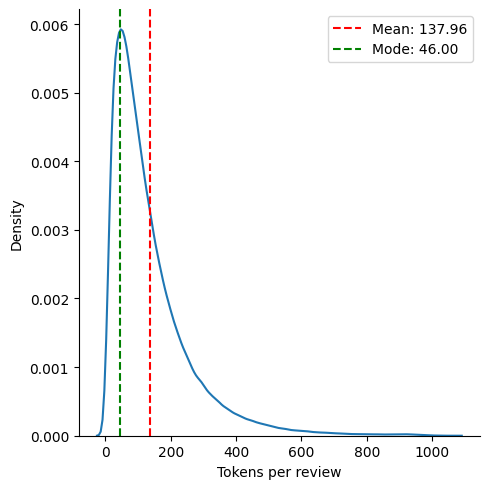

In [7]:
# Concatenate the lengths of documents from the train and test datasets
n_tokens_per_review = np.concatenate((np.array(train['length']),np.array(test['length']) ))

# Plot the distribution of document lengths using a kernel density estimate (KDE) plot
sns.displot(data=pd.DataFrame(n_tokens_per_review, columns= ['Tokens per review']), x='Tokens per review', kind="kde")

# Calculate the mean, median, and mode of the number of tokens per review
mean_length = np.mean(np.array(n_tokens_per_review))
median_length = np.median(np.array(n_tokens_per_review))
mode_length = np.argmax(np.bincount(n_tokens_per_review))

# Add vertical lines to the plot indicating the mean and mode of the number of token
plt.axvline(mean_length, color='r', linestyle='--', label=f'Mean: {mean_length:.2f}')
plt.axvline(mode_length, color='g', linestyle='--', label=f'Mode: {mode_length:.2f}')
plt.legend()

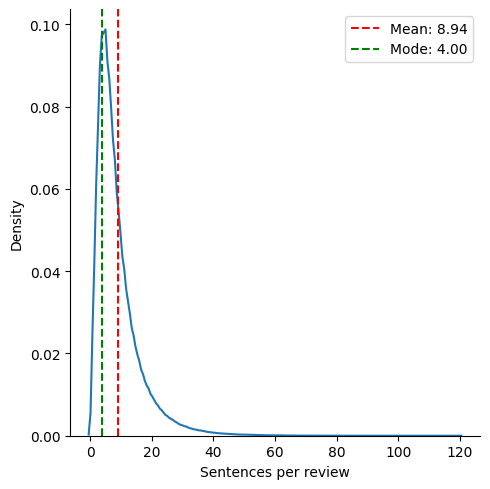

In [8]:
# Do the same for the number of sentences in each document.
n_sentences_per_review = np.concatenate((np.array(train['n_sentences']),np.array(test['n_sentences']) ))

sns.displot(data=pd.DataFrame(n_sentences_per_review, columns= ['Sentences per review']), x='Sentences per review', kind="kde")

mean_length = np.mean(np.array(n_sentences_per_review))
median_length = np.median(np.array(n_sentences_per_review))
mode_length = np.argmax(np.bincount(n_sentences_per_review))

plt.axvline(mean_length, color='r', linestyle='--', label=f'Mean: {mean_length:.2f}')
plt.axvline(mode_length, color='g', linestyle='--', label=f'Mode: {mode_length:.2f}')
plt.legend()

In [9]:
# Find the document with the maximum number of tokens
max_tokens_index = int(np.argmax(n_tokens_per_review))
max_tokens_length = train[max_tokens_index]['length']
max_tokens_label = train[max_tokens_index]['label']

print(f"The document with the maximum number of tokens has a length of {max_tokens_length} tokens.")
print(f"It corresponds to a {max_tokens_label} stars review.")

The document with the maximum number of tokens has a length of 1065 tokens.
It corresponds to a 3 stars review.


In [11]:
# Let's find the most common tokens
full_dataset = concatenate_datasets([train,test])

# Convert the dataset to a pandas dataframe 
full_df = full_dataset.to_pandas()

# Since for each document there is a list of tokens, to have a single list with all the tokens we explode the dataframe on the tokens column
df_exploded = full_df.explode('tokens_no_punc')

# Count the the occurencies for each unique token and sort
words_count = df_exploded.groupby('tokens_no_punc').size().reset_index(name='count')
sorted_words_count = words_count.sort_values(by='count', ascending=False)

In [ ]:
# We are interested to the most common words, so the stopwords are not of interest

nltk.download('stopwords')
exclude_words = stopwords.words('english')
exclude_words.extend(["n't", "'s", '  ','...'])

# To accelerate times and only view the N top words
N = 1000
sorted_words_count_reduced = sorted_words_count[:N]

# View the tokens that are not stopwords
sorted_words_count_reduced = sorted_words_count_reduced[~sorted_words_count_reduced['tokens_no_punc'].isin(exclude_words)]
sorted_words_count_reduced[:20]

In [ ]:
# Print the 10 most common tokens
print("Top 10 most common tokens in the train set:")
for token, count in zip(sorted_words_count_reduced['tokens_no_punc'][:10],sorted_words_count_reduced['count'][:10]):
    print(f"{token}\t-> {count}")

Top 10 most common tokens in the train set:
place	-> 250505
good	-> 250117
food	-> 241954
like	-> 207118
just	-> 205447
service	-> 184942
great	-> 177019
time	-> 174050
really	-> 147578
don	-> 122863


In [ ]:
# Compute the average length of reviews for each star rating
labels = np.concatenate((np.array(train['label']), np.array(test['label']))) + 1
stars_vs_len_dict = {i+1:[] for i in range(5)} # Dictionary to store the lengths of reviews for each star rating

for len,star in zip(n_tokens_per_review, labels):
    stars_vs_len_dict[star].append(len)
stars_vs_len_dict = {lab: np.mean(np.array(len)) for lab, len in stars_vs_len_dict.items()}

In [ ]:
# Print average length of reviews for each star rating
for star, length in stars_vs_len_dict.items():
    print(f"{star} stars : {length:.2f} tokens avg")

1 stars : 155.43 tokens avg
2 stars : 156.66 tokens avg
3 stars : 143.04 tokens avg
4 stars : 127.02 tokens avg
5 stars : 107.67 tokens avg


Length of reviews seems to be proportional to how bad was the experience. So longest reviews corresponds to the worst ones.

In [ ]:
# Check if the dataset is balanced
unique, count = np.unique(labels, return_counts=True)

# Print the unique labels and their counts
print("Unique Labels:", unique)
print("Label Counts:", count)

Unique Labels: [1 2 3 4 5]
Label Counts: [140000 140000 140000 140000 140000]


## Vectorization
We will try following settings for vectorization:
- Word representation: CountVectorizer vs. TfidfVectorizer
- N-grams: unigram & bigram
- Minimum document frequency: 5
- Convert to lowercase
- Use stop words
%time X_train, X_dev, X_test, y_train, y_dev, y_test = extract_features(df_train, df_val, df_test)

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

def extract_features(train, test):
    vectorizer = CountVectorizer(min_df=5, stop_words='english')
    vectorizer.fit(train['text'])
    X_train = vectorizer.transform(train['text'])
    y_train = train['label']
    X_test = vectorizer.transform(test['text'])
    y_test = test['label']
    return X_train, X_test, y_train, y_test

In [ ]:
X_train, X_test, y_train, y_test = extract_features(train, test)

# Experiments and Results
We will use machine learning models and transformer-based models
## Machine Learning
Navie Bayes, Logistic Regression, Random Forest, and SGD Classifier will be used in this section.

#### Evaluation Metrics
- Precision, recall, F1 score
- Accuracy
- Confusion matrix

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import f1_score, mean_squared_error
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

# Function to evaluate a model on a dataset
def evaluate_model_Xy(model, X, y, y_pred=None, split="Training", model_name="model"):
  if y_pred is None:
    y_pred = model.predict(X)

  accuracy = accuracy_score(y, y_pred)

  # Specify the split on which evaluation is perfromed and the obtained accuracy
  print(split + ' Set')
  print("Accuracy:", accuracy)
  print()

  # Print the classification report and confusion matrix
  print(classification_report(y, y_pred, digits=4, target_names=['1*', '2*', '3*', '4*', '5*']))
  disp = confusion_matrix(y, y_pred, 
                          normalize='true',
                          labels=['1*', '2*', '3*', '4*', '5*'])
  sns.heatmap(disp, annot=True, fmt=".2f", cmap="Blues")
  plt.savefig(model_name + "_" + split.lower() + ".eps")
  plt.show()
  print()

  return {split: accuracy}

In [ ]:
def evaluate_model(model, model_name="model",
                   y_train_pred=None, y_dev_pred=None, y_test_pred=None):
    # Evaluate the model on the training, validation, and test sets, and return the results as a dictionary
    results = {}
    
    results.update(evaluate_model_Xy(model, X_train, y_train, y_train_pred, "Train", model_name))
    results.update(evaluate_model_Xy(model, X_test, y_test, y_test_pred, "Test", model_name))
    
    return results

In [ ]:
# Create an empty dictionary to hold all the evaluation results
evaluation_results = {}

### Naive Bayes Classifier

In [ ]:
from sklearn.naive_bayes import MultinomialNB

clf_nb = MultinomialNB(alpha=0.5)

In [ ]:
%time clf_nb.fit(X_train, y_train)

CPU times: user 5.7 s, sys: 358 ms, total: 6.06 s
Wall time: 2.02 s


MultinomialNB(alpha=0.5)

Training Set
Accuracy: 0.7580038461538462

              precision    recall  f1-score   support

           0     0.7267    0.7877    0.7560    104000
           1     0.7174    0.7013    0.7092    104000
           2     0.7723    0.7461    0.7590    104000
           3     0.7414    0.7832    0.7617    104000
           4     0.8425    0.7718    0.8056    104000

    accuracy                         0.7580    520000
   macro avg     0.7601    0.7580    0.7583    520000
weighted avg     0.7601    0.7580    0.7583    520000



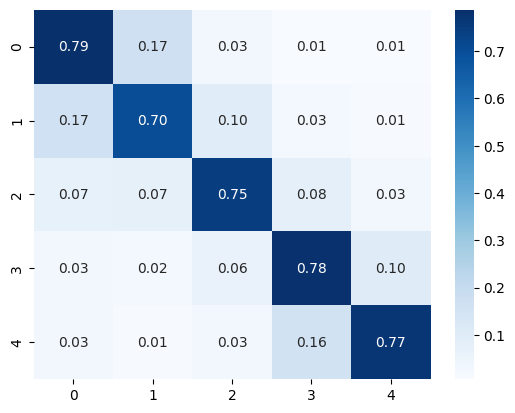


Validation Set
Accuracy: 0.5554846153846154

              precision    recall  f1-score   support

           0     0.6391    0.6998    0.6681     26000
           1     0.4972    0.4777    0.4872     26000
           2     0.4836    0.4795    0.4816     26000
           3     0.4812    0.5301    0.5044     26000
           4     0.6936    0.5903    0.6378     26000

    accuracy                         0.5555    130000
   macro avg     0.5589    0.5555    0.5558    130000
weighted avg     0.5589    0.5555    0.5558    130000



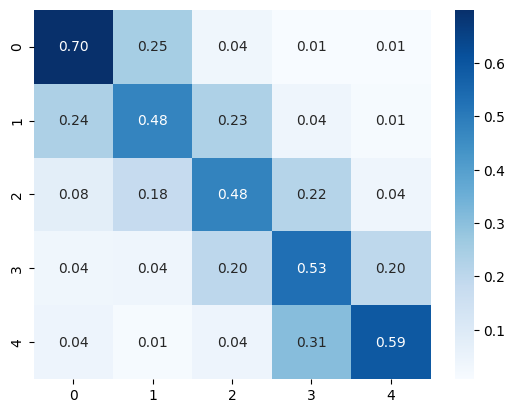


Testing Set
Accuracy: 0.55294

              precision    recall  f1-score   support

           0     0.6300    0.6853    0.6565     10000
           1     0.4921    0.4760    0.4839     10000
           2     0.4862    0.4790    0.4826     10000
           3     0.4846    0.5399    0.5107     10000
           4     0.6912    0.5845    0.6334     10000

    accuracy                         0.5529     50000
   macro avg     0.5568    0.5529    0.5534     50000
weighted avg     0.5568    0.5529    0.5534     50000



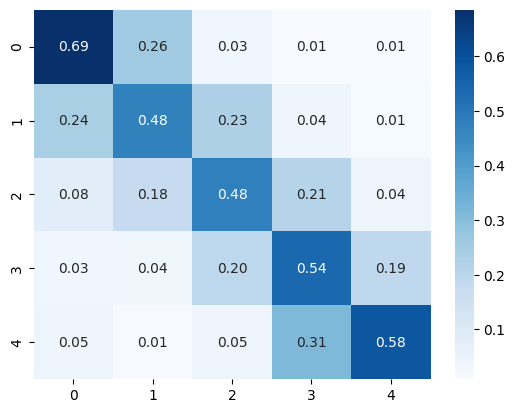

In [ ]:
nb_results = evaluate_model(clf_nb, model_name="nb")
evaluation_results['Naive Bayes'] = nb_results

### Logistic Regression Classifier-Lasso

In [ ]:
# Logistic Regression with L2 regularization
clf_lr_lasso = LogisticRegression(penalty='l2',
                                  tol=1e-4,
                                  C=5.0,
                                  fit_intercept=True,
                                  class_weight='balanced',
                                  random_state=0,
                                  solver='lbfgs',
                                  max_iter=500,
                                  multi_class='auto',
                                  verbose=1,
                                  n_jobs=-1)

In [ ]:
clf_lr_lasso.fit(X_train, y_train)

Training Set
Accuracy: 0.9579153846153846

              precision    recall  f1-score   support

           0     0.9613    0.9748    0.9680    104000
           1     0.9600    0.9540    0.9570    104000
           2     0.9563    0.9435    0.9498    104000
           3     0.9552    0.9481    0.9517    104000
           4     0.9567    0.9692    0.9629    104000

    accuracy                         0.9579    520000
   macro avg     0.9579    0.9579    0.9579    520000
weighted avg     0.9579    0.9579    0.9579    520000



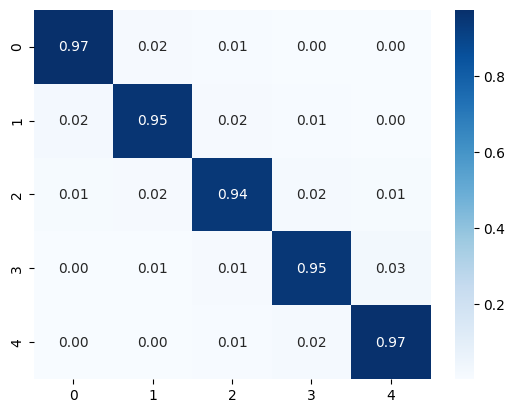


Validation Set
Accuracy: 0.583176923076923

              precision    recall  f1-score   support

           0     0.7152    0.7466    0.7306     26000
           1     0.5260    0.5076    0.5167     26000
           2     0.4986    0.4837    0.4910     26000
           3     0.4948    0.4908    0.4928     26000
           4     0.6677    0.6873    0.6773     26000

    accuracy                         0.5832    130000
   macro avg     0.5805    0.5832    0.5817    130000
weighted avg     0.5805    0.5832    0.5817    130000



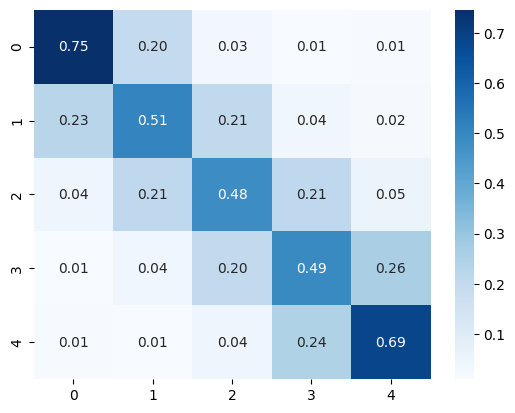


Testing Set
Accuracy: 0.57932

              precision    recall  f1-score   support

           0     0.7073    0.7393    0.7230     10000
           1     0.5194    0.5035    0.5113     10000
           2     0.4952    0.4838    0.4895     10000
           3     0.4936    0.4888    0.4912     10000
           4     0.6690    0.6812    0.6750     10000

    accuracy                         0.5793     50000
   macro avg     0.5769    0.5793    0.5780     50000
weighted avg     0.5769    0.5793    0.5780     50000



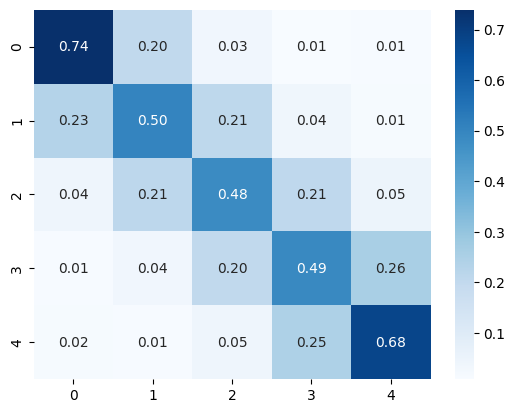

In [ ]:
lr_results = evaluate_model(clf_lr_lasso, model_name="lr_tfidf_lasso")
evaluation_results['Logistic Regression L2'] = lr_results

### Random Forest Classifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Random Forest Classifier with 500 trees and Gini impurity as criterion. 
# No restrictions on the depth of the trees.
clf_rf = RandomForestClassifier(n_estimators=500,
                                criterion="gini",
                                max_depth=None, 
                                min_samples_split=2,
                                min_samples_leaf=10, 
                                max_features="auto", 
                                n_jobs=-1,
                                verbose=1,
                                random_state=0,
                                class_weight='balanced')

In [ ]:
clf_rf.fit(X_train, y_train)

/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  5.6min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 12.7min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 14.3min finished


RandomForestClassifier(class_weight='balanced', max_features='auto',
                       min_samples_leaf=10, n_estimators=500, n_jobs=-1,
                       random_state=0, verbose=1)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   20.3s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  1.5min
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  3.5min
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:  3.9min finished


Training Set
Accuracy: 0.5955423076923076

              precision    recall  f1-score   support

           0     0.6020    0.8221    0.6950    104000
           1     0.6029    0.4563    0.5195    104000
           2     0.6021    0.4899    0.5403    104000
           3     0.5715    0.4786    0.5210    104000
           4     0.5959    0.7307    0.6564    104000

    accuracy                         0.5955    520000
   macro avg     0.5949    0.5955    0.5864    520000
weighted avg     0.5949    0.5955    0.5864    520000



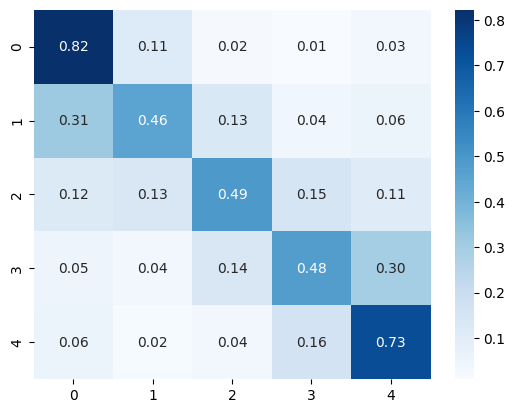

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.3s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   23.2s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   53.3s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:   59.9s finished


Validation Set
Accuracy: 0.5327692307692308

              precision    recall  f1-score   support

           0     0.5759    0.8038    0.6711     26000
           1     0.5098    0.3832    0.4376     26000
           2     0.4942    0.3982    0.4410     26000
           3     0.4772    0.3912    0.4300     26000
           4     0.5602    0.6874    0.6173     26000

    accuracy                         0.5328    130000
   macro avg     0.5235    0.5328    0.5194    130000
weighted avg     0.5235    0.5328    0.5194    130000



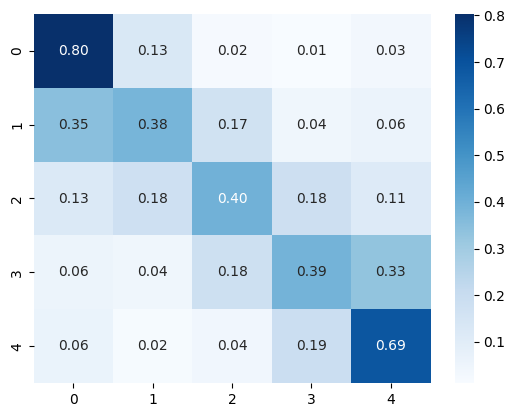

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    8.6s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   20.2s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:   22.8s finished


Testing Set
Accuracy: 0.531

              precision    recall  f1-score   support

           0     0.5731    0.7993    0.6675     10000
           1     0.5094    0.3832    0.4374     10000
           2     0.4945    0.3970    0.4404     10000
           3     0.4727    0.3918    0.4285     10000
           4     0.5599    0.6837    0.6156     10000

    accuracy                         0.5310     50000
   macro avg     0.5219    0.5310    0.5179     50000
weighted avg     0.5219    0.5310    0.5179     50000



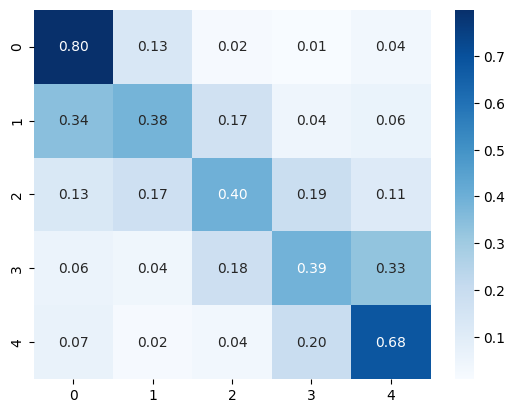

In [ ]:
rf_results = evaluate_model(clf_rf, model_name="rf")
evaluation_results['Random Forest'] = rf_results

### SGDClassifier

In [ ]:
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# Stochastic Gradient Descent Classifier with hinge loss, L2 regularization, and optimal learning rate.
clf_sgd = make_pipeline(StandardScaler(with_mean=False),
                        SGDClassifier(loss='hinge',
                                      penalty='l2',
                                      alpha=30,
                                      max_iter=1000, 
                                      tol=1e-3,
                                      shuffle=True,
                                      verbose=1,
                                      n_jobs=-1,
                                      random_state=0,
                                      learning_rate='optimal',
                                      early_stopping=True,
                                      class_weight='balanced'))

In [ ]:
clf_sgd.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


-- Epoch 1-- Epoch 1
-- Epoch 1

-- Epoch 1
Norm: 0.10, NNZs: 883316, Bias: -0.006211, T: 468000, Avg. loss: 0.569856
Total training time: 0.60 seconds.
-- Epoch 2
Norm: 0.10, NNZs: 885152, Bias: -0.005805, T: 468000, Avg. loss: 0.569962
Total training time: 0.67 seconds.
Norm: 0.11, NNZs: 880627, Bias: -0.006046, T: 468000, Avg. loss: 0.504718
Total training time: 0.67 seconds.
Norm: 0.10, NNZs: 879595, Bias: -0.005994, T: 468000, Avg. loss: 0.556671
Total training time: 0.66 seconds.
-- Epoch 2
-- Epoch 2
-- Epoch 2
Norm: 0.10, NNZs: 884861, Bias: -0.006310, T: 936000, Avg. loss: 0.536765
Total training time: 1.26 seconds.
-- Epoch 3
Norm: 0.10, NNZs: 886346, Bias: -0.005906, T: 936000, Avg. loss: 0.536398
Total training time: 1.31 seconds.
Norm: 0.11, NNZs: 882990, Bias: -0.006140, T: 936000, Avg. loss: 0.473049
Total training time: 1.33 seconds.
Norm: 0.10, NNZs: 881931, Bias: -0.006089, T: 936000, Avg. loss: 0.525360
Total training time: 1.32 seconds.
-- Epoch 3
-- Epoch 3
-- Epoc

[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    6.5s finished


Pipeline(steps=[('standardscaler', StandardScaler(with_mean=False)),
                ('sgdclassifier',
                 SGDClassifier(alpha=30, class_weight='balanced',
                               early_stopping=True, n_jobs=-1, random_state=0,
                               verbose=1))])

Training Set
Accuracy: 0.8175461538461538

              precision    recall  f1-score   support

           0     0.7128    0.9398    0.8107    104000
           1     0.8733    0.7010    0.7777    104000
           2     0.8871    0.7524    0.8142    104000
           3     0.8504    0.7875    0.8178    104000
           4     0.8212    0.9070    0.8620    104000

    accuracy                         0.8175    520000
   macro avg     0.8289    0.8175    0.8165    520000
weighted avg     0.8289    0.8175    0.8165    520000



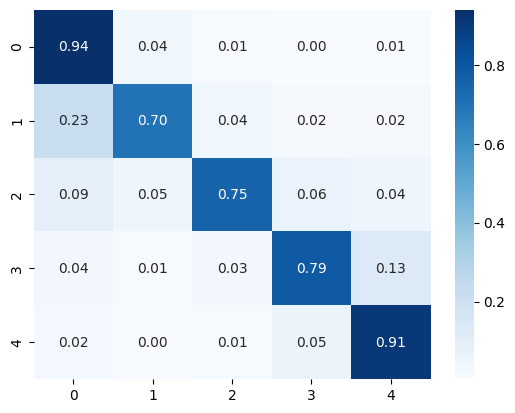


Validation Set
Accuracy: 0.5384

              precision    recall  f1-score   support

           0     0.5590    0.8331    0.6690     26000
           1     0.5187    0.3587    0.4241     26000
           2     0.5024    0.3669    0.4241     26000
           3     0.4683    0.4259    0.4461     26000
           4     0.6004    0.7075    0.6495     26000

    accuracy                         0.5384    130000
   macro avg     0.5297    0.5384    0.5226    130000
weighted avg     0.5297    0.5384    0.5226    130000



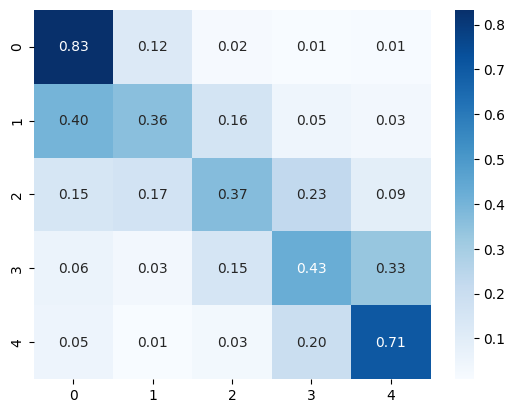


Testing Set
Accuracy: 0.53678

              precision    recall  f1-score   support

           0     0.5523    0.8227    0.6609     10000
           1     0.5140    0.3528    0.4184     10000
           2     0.5019    0.3656    0.4231     10000
           3     0.4703    0.4327    0.4507     10000
           4     0.6040    0.7101    0.6528     10000

    accuracy                         0.5368     50000
   macro avg     0.5285    0.5368    0.5212     50000
weighted avg     0.5285    0.5368    0.5212     50000



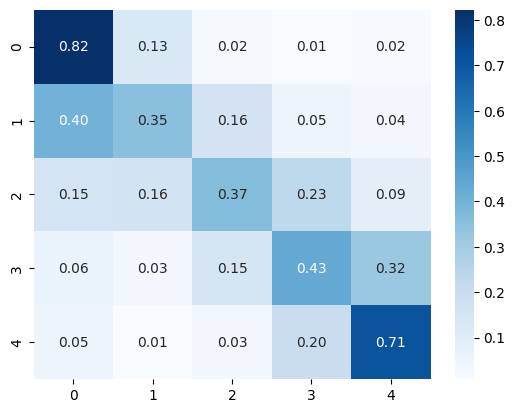

In [ ]:
sgd_results = evaluate_model(clf_sgd, model_name="sgd")
evaluation_results['SGD'] = sgd_results

### Performance comparison

In [ ]:
import matplotlib.pyplot as plt

# Extract the model names and accuracy values from the evaluation_results dictionary
model_names = list(evaluation_results.keys())
test_accuracies = [result['Test'] for result in evaluation_results.values()]
train_accuracies = [result['Train'] for result in evaluation_results.values()]

# Create a line plot
plt.figure(figsize=(10, 6))
plt.plot(model_names, test_accuracies, marker='o', label='Test')
plt.plot(model_names, train_accuracies, marker='o', label='Train')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Model Performance')
plt.ylim(0, 1)  # Set the y-axis limits to 0 and 1
plt.xticks(rotation=45)  # Rotate the x-axis labels for better readability
plt.legend()  # Show the legend
plt.show()

### Clustering

In [ ]:
# Load the dataset
dataset = load_from_disk("yelp_review_full")

In [ ]:
# Convert the 'text' column of the dataset into a list
data_text = []
for split in dataset.keys():
    data_text.extend(dataset[split]['text'])

## word2vec

Here we employ word2vec embedding and use it to train our machine learning models. Then we compare the performance for different choiches of the dimension of this embedding on Logistic Regression model with Lasso regularization.

In [ ]:
from gensim.models.word2vec import Word2Vec

# Embed the tokens using Word2Vec with embedding size 70, window size of 50 words. 
# Words that appear less than 10 times are ignored.
modelsize = 70
model = Word2Vec(train_dataset['tokens'], vector_size=modelsize, min_count=10, window=50, workers=16)
len(model.wv)

model.save('word2vecmodel_rightembedding.kv')

43014

In [ ]:
# Function to vectorize a list of documents using a Word2Vec model
def vectorize(docs, embedding_model=model.wv, useSum=True):
    vectors = np.zeros((len(docs), modelsize)) 

    for i in range(len(docs)):
        tokens = docs[i]
        embeddings = [embedding_model.get_vector(token) for token in tokens if token in embedding_model] 
        if len(embeddings) > 0:
            if useSum:
                vectors[i] = sum(embeddings)
            else:
                vectors[i] = np.mean(embeddings, axis=0)
    return vectors

# Vectorize the training and test datasets using the Word2Vec model
train_x_vector = vectorize(train_dataset['tokens'])
train_y = train_dataset['label']

test_x_vector = vectorize(test_dataset['tokens'])
test_y = test_dataset['label']

### Logistic Regression Classifier-Lasso

In [ ]:
from sklearn.linear_model import LogisticRegression
clf_lr_lasso = LogisticRegression(
                                  tol=1e-4,
                                  fit_intercept=True,
                                  class_weight='balanced',
                                  random_state=0,
                                  solver='lbfgs',
                                  max_iter=500,
                                  multi_class='auto',
                                  verbose=1,
                                  n_jobs=-1)

In [ ]:
clf_lr_lasso.fit(train_x_vector, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          355     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.36908D+05    |proj g|=  1.28187D+07


 This problem is unconstrained.



At iterate   50    f=  5.51977D+05    |proj g|=  3.50525D+05

At iterate  100    f=  5.51140D+05    |proj g|=  4.70614D+04

At iterate  150    f=  5.50641D+05    |proj g|=  3.98874D+04

At iterate  200    f=  5.50543D+05    |proj g|=  1.15812D+04

At iterate  250    f=  5.50534D+05    |proj g|=  9.11737D+03

At iterate  300    f=  5.50531D+05    |proj g|=  4.65804D+03

At iterate  350    f=  5.50527D+05    |proj g|=  7.09142D+03

At iterate  400    f=  5.50519D+05    |proj g|=  7.71221D+03

At iterate  450    f=  5.50455D+05    |proj g|=  3.83637D+04

At iterate  500    f=  5.50398D+05    |proj g|=  1.11693D+04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(class_weight='balanced', max_iter=500, n_jobs=-1,
                   random_state=0, verbose=1)

Training Set
Accuracy: 0.5606403846153846

              precision    recall  f1-score   support

           0     0.6755    0.7530    0.7121    104000
           1     0.5048    0.4493    0.4755    104000
           2     0.4735    0.4475    0.4601    104000
           3     0.4825    0.4226    0.4506    104000
           4     0.6223    0.7308    0.6722    104000

    accuracy                         0.5606    520000
   macro avg     0.5517    0.5606    0.5541    520000
weighted avg     0.5517    0.5606    0.5541    520000



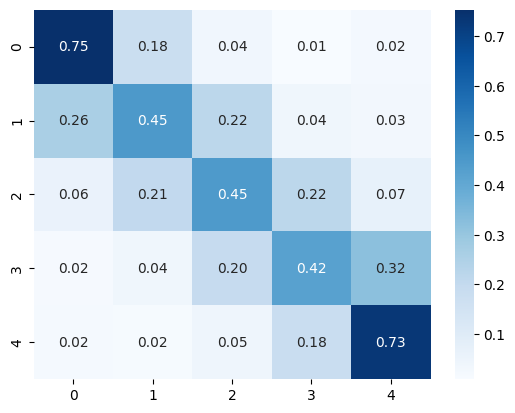


Validation Set
Accuracy: 0.5606461538461538

              precision    recall  f1-score   support

           0     0.6760    0.7580    0.7147     26000
           1     0.5032    0.4456    0.4726     26000
           2     0.4714    0.4506    0.4608     26000
           3     0.4823    0.4195    0.4487     26000
           4     0.6249    0.7295    0.6731     26000

    accuracy                         0.5606    130000
   macro avg     0.5516    0.5606    0.5540    130000
weighted avg     0.5516    0.5606    0.5540    130000



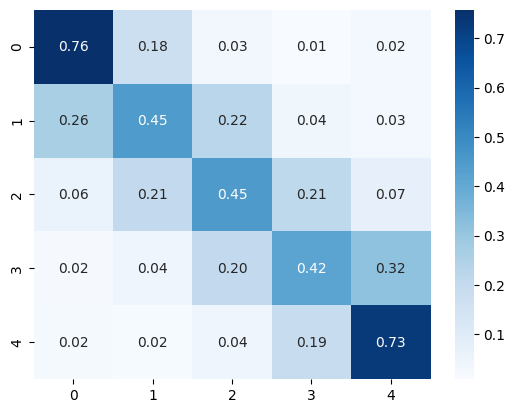


Testing Set
Accuracy: 0.56146

              precision    recall  f1-score   support

           0     0.6698    0.7502    0.7077     10000
           1     0.5029    0.4489    0.4744     10000
           2     0.4774    0.4488    0.4627     10000
           3     0.4865    0.4337    0.4586     10000
           4     0.6279    0.7257    0.6733     10000

    accuracy                         0.5615     50000
   macro avg     0.5529    0.5615    0.5553     50000
weighted avg     0.5529    0.5615    0.5553     50000



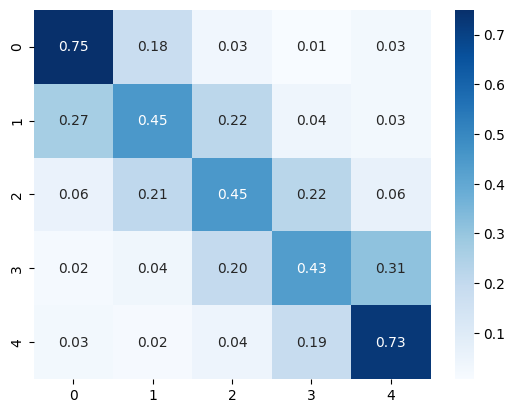

In [ ]:
evaluate_model(clf_lr_lasso, model_name="lr_tfidf_lasso")

C:\Users\melan\AppData\Local\Temp\ipykernel_1792\1372528146.py:6: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  plt.plot(data['dimension_embedding'], data['accuracy_test_set'], 'ro', color='royalblue')


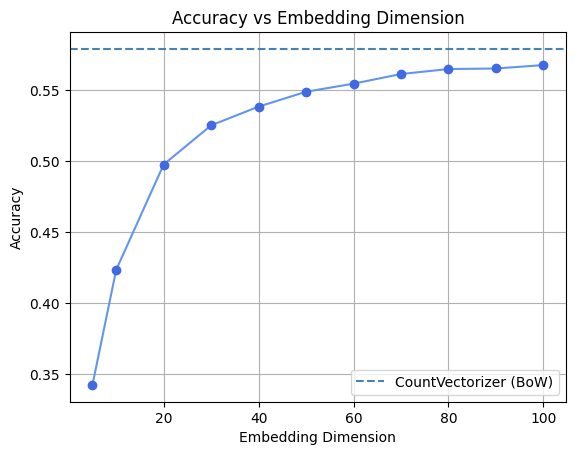

In [11]:
data=pd.DataFrame()
data['dimension_embedding']=np.array([5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100])
data['accuracy_test_set']=np.array([0.3424, 0.4235, 0.4978, 0.5254,  0.5386, 0.5491, 0.5548, 0.5616,  0.5651,  0.5655,  0.5679])

sns.lineplot(data=data, x="dimension_embedding", y="accuracy_test_set", color='cornflowerblue')
plt.plot(data['dimension_embedding'], data['accuracy_test_set'], 'ro', color='royalblue')
plt.axhline(y=0.5793 , color='steelblue', linestyle='--', label='CountVectorizer (BoW)')
plt.grid()
plt.legend()
plt.title('Accuracy vs Embedding Dimension')
plt.xlabel('Embedding Dimension')
plt.ylabel('Accuracy')
plt.show()

COMMENT??

## Deep Learning